In [1]:
! pip install optuna

In [2]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

In [3]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torchvision import datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

import optuna
from tqdm import tqdm

Random Seed:  999


In [ ]:
# Root directory for dataset
dataroot = "data/cifar10_data"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [ ]:
transform = transforms.Compose([
    transforms.Resize(64),  # Resize to 64x64
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.CIFAR10(
    root=dataroot,
    train=True,
    download=True,
    transform=transform
)

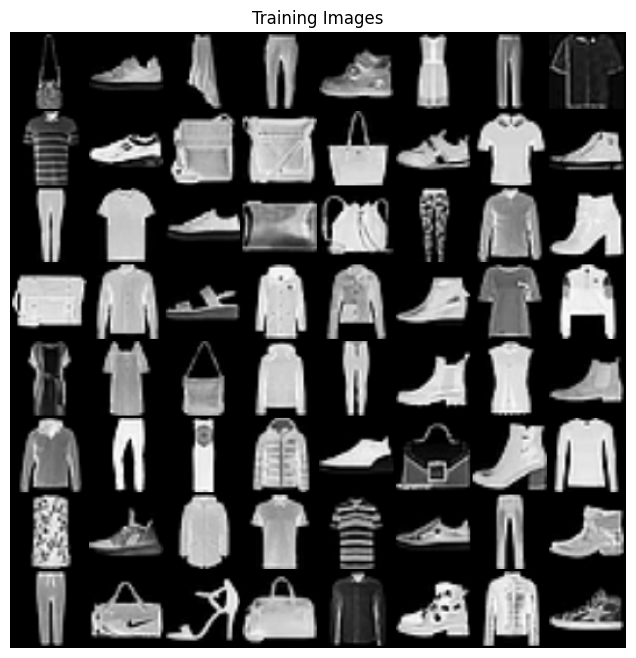

In [6]:
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [7]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [8]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu, nz, ngf, nc):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

Now, we can instantiate the generator and apply the `weights_init`
function. Check out the printed model to see how the generator object is
structured.


In [9]:
class Discriminator(nn.Module):
    def __init__(self, ngpu, ndf, nc):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [10]:
def objective(trial):
    print(f"Starting trial {trial.number}...")

    # Define hyperparameters to tune
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)  # Learning rate
    nz = trial.suggest_int('nz', 50, 200)  # Latent vector size
    ngf = trial.suggest_categorical('ngf', [32, 64, 128])  # Generator feature maps
    ndf = trial.suggest_categorical('ndf', [32, 64, 128])  # Discriminator feature maps
    beta1 = trial.suggest_float('beta1', 0.3, 0.9)  # Tuning beta1

    # Initialize models
    # Create the generator
    netG = Generator(ngpu=ngpu, nz=nz, ngf=ngf, nc=1).to(device)

    # Handle multi-GPU if desired
    if (device.type == 'cuda') and (ngpu > 1):
        netG = nn.DataParallel(netG, list(range(ngpu)))

    # Apply the ``weights_init`` function to randomly initialize all weights
    #  to ``mean=0``, ``stdev=0.02``.
    netG.apply(weights_init)

    # Create the Discriminator
    netD = Discriminator(ngpu=ngpu, ndf=ndf, nc=1).to(device)

    # Handle multi-GPU if desired
    if (device.type == 'cuda') and (ngpu > 1):
        netD = nn.DataParallel(netD, list(range(ngpu)))

    # Apply the ``weights_init`` function to randomly initialize all weights
    # like this: ``to mean=0, stdev=0.2``.
    netD.apply(weights_init)


    # Set up Adam optimizers
    optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

    # Binary Cross Entropy Loss
    criterion = nn.BCELoss()

    # Initialize fixed noise for evaluation
    fixed_noise = torch.randn(64, nz, 1, 1, device=device)

    # Lists to keep track of progress
    img_list = []
    G_losses = []
    D_losses = []
    iters = 0

    # Training loop
    for epoch in range(num_epochs):
        epoch_D_loss = 0
        epoch_G_loss = 0
        print(f"Epoch {epoch+1}/{num_epochs}...")

        for i, data in enumerate(tqdm(dataloader, desc=f"Training Epoch {epoch+1}"), 0):
            ############################
            # (1) Update D network
            ###########################
            netD.zero_grad()
            real_cpu = data[0].to(device)
            b_size = real_cpu.size(0)
            label = torch.full((b_size,), 1., dtype=torch.float, device=device)

            # Flatten the output of the discriminator
            output = netD(real_cpu).view(-1)
            errD_real = criterion(output, label)
            errD_real.backward()
            D_x = output.mean().item()

            noise = torch.randn(b_size, nz, 1, 1, device=device)
            fake = netG(noise)
            label.fill_(0.)
            # Flatten the output of the discriminator
            output = netD(fake.detach()).view(-1)
            errD_fake = criterion(output, label)
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            errD = errD_real + errD_fake
            optimizerD.step()

            ############################
            # (2) Update G network
            ###########################
            netG.zero_grad()
            label.fill_(1.)  # fake labels are real for generator cost
            # Flatten the output of the discriminator
            output = netD(fake).view(-1)
            errG = criterion(output, label)
            errG.backward()
            D_G_z2 = output.mean().item()
            optimizerG.step()

            # Save losses for later analysis
            G_losses.append(errG.item())
            D_losses.append(errD.item())

            epoch_D_loss += errD.item()
            epoch_G_loss += errG.item()

            if iters % 50 == 0:
                print(f"Iteration {iters}: Loss_D: {errD.item():.4f}\tLoss_G: {errG.item():.4f}")

            iters += 1

        # Log the average losses for the epoch
        print(f"Epoch {epoch+1}/{num_epochs} - Avg Loss D: {epoch_D_loss / len(dataloader):.4f} - Avg Loss G: {epoch_G_loss / len(dataloader):.4f}")

        # Save generated images
        with torch.no_grad():
            fake = netG(fixed_noise).detach().cpu()
        img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

    # Final loss for the objective function
    final_loss = sum(D_losses)
    print(f"Trial {trial.number} complete - Total Discriminator Loss: {final_loss:.4f}")
    return final_loss  # Minimize the discriminator loss

In [11]:
# Run the Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)  # Run 50 trials to explore different hyperparameters

# Print the best hyperparameters found
print("Best hyperparameters: ", study.best_params)

# After the study is complete, you can retrieve the best model settings
best_hyperparams = study.best_params
print(f"Best Hyperparameters: {best_hyperparams}")

[I 2025-06-01 01:22:40,675] A new study created in memory with name: no-name-19f93c97-dcbe-4f88-a0b5-656f69e86dd8
<ipython-input-10-224cc80281a0>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)  # Learning rate


Starting trial 0...
Epoch 1/5...


Training Epoch 1:   0%|          | 1/469 [00:01<08:55,  1.14s/it]

Iteration 0: Loss_D: 1.4474	Loss_G: 9.4683


Training Epoch 1:  11%|█         | 52/469 [00:11<01:21,  5.11it/s]

Iteration 50: Loss_D: 0.0000	Loss_G: 41.9919


Training Epoch 1:  22%|██▏       | 101/469 [00:21<01:21,  4.54it/s]

Iteration 100: Loss_D: 0.0000	Loss_G: 41.8317


Training Epoch 1:  32%|███▏      | 151/469 [00:31<01:03,  5.03it/s]

Iteration 150: Loss_D: 0.0000	Loss_G: 41.5673


Training Epoch 1:  43%|████▎     | 202/469 [00:41<00:50,  5.27it/s]

Iteration 200: Loss_D: 0.0000	Loss_G: 41.5993


Training Epoch 1:  54%|█████▎    | 252/469 [00:50<00:40,  5.30it/s]

Iteration 250: Loss_D: 0.0000	Loss_G: 41.2131


Training Epoch 1:  64%|██████▍   | 302/469 [01:00<00:31,  5.33it/s]

Iteration 300: Loss_D: 0.0000	Loss_G: 40.9695


Training Epoch 1:  75%|███████▌  | 352/469 [01:09<00:22,  5.23it/s]

Iteration 350: Loss_D: 0.0000	Loss_G: 40.9298


Training Epoch 1:  86%|████████▌ | 402/469 [01:19<00:12,  5.40it/s]

Iteration 400: Loss_D: 0.0000	Loss_G: 40.8877


Training Epoch 1:  96%|█████████▋| 452/469 [01:28<00:03,  5.40it/s]

Iteration 450: Loss_D: 0.0000	Loss_G: 40.5710


Training Epoch 1: 100%|██████████| 469/469 [01:31<00:00,  5.12it/s]


Epoch 1/5 - Avg Loss D: 0.0499 - Avg Loss G: 39.7779
Epoch 2/5...


Training Epoch 2:   7%|▋         | 33/469 [00:06<01:21,  5.35it/s]

Iteration 500: Loss_D: 0.0000	Loss_G: 40.6015


Training Epoch 2:  18%|█▊        | 83/469 [00:16<01:15,  5.11it/s]

Iteration 550: Loss_D: 0.0000	Loss_G: 40.6655


Training Epoch 2:  28%|██▊       | 133/469 [00:25<01:02,  5.35it/s]

Iteration 600: Loss_D: 0.0000	Loss_G: 40.4707


Training Epoch 2:  39%|███▉      | 183/469 [00:34<00:53,  5.31it/s]

Iteration 650: Loss_D: 0.0000	Loss_G: 39.9395


Training Epoch 2:  50%|████▉     | 233/469 [00:44<00:44,  5.33it/s]

Iteration 700: Loss_D: 0.0000	Loss_G: 39.8740


Training Epoch 2:  60%|██████    | 283/469 [00:53<00:35,  5.19it/s]

Iteration 750: Loss_D: 0.0000	Loss_G: 39.3647


Training Epoch 2:  71%|███████   | 333/469 [01:03<00:25,  5.32it/s]

Iteration 800: Loss_D: 0.0000	Loss_G: 37.4790


Training Epoch 2:  82%|████████▏ | 383/469 [01:12<00:16,  5.32it/s]

Iteration 850: Loss_D: 0.0000	Loss_G: 47.3057


Training Epoch 2:  92%|█████████▏| 433/469 [01:22<00:06,  5.34it/s]

Iteration 900: Loss_D: 0.0000	Loss_G: 47.0223


Training Epoch 2: 100%|██████████| 469/469 [01:28<00:00,  5.28it/s]


Epoch 2/5 - Avg Loss D: 0.0063 - Avg Loss G: 41.9800
Epoch 3/5...


Training Epoch 3:   3%|▎         | 14/469 [00:02<01:30,  5.05it/s]

Iteration 950: Loss_D: 0.0000	Loss_G: 47.0889


Training Epoch 3:  14%|█▎        | 64/469 [00:12<01:15,  5.34it/s]

Iteration 1000: Loss_D: 0.0000	Loss_G: 46.8863


Training Epoch 3:  24%|██▍       | 114/469 [00:21<01:06,  5.33it/s]

Iteration 1050: Loss_D: 0.0000	Loss_G: 46.9949


Training Epoch 3:  35%|███▍      | 164/469 [00:31<00:56,  5.36it/s]

Iteration 1100: Loss_D: 0.0000	Loss_G: 46.6014


Training Epoch 3:  46%|████▌     | 214/469 [00:40<00:49,  5.17it/s]

Iteration 1150: Loss_D: 0.0000	Loss_G: 46.5574


Training Epoch 3:  56%|█████▋    | 264/469 [00:49<00:38,  5.34it/s]

Iteration 1200: Loss_D: 0.0000	Loss_G: 46.7863


Training Epoch 3:  67%|██████▋   | 314/469 [00:59<00:29,  5.30it/s]

Iteration 1250: Loss_D: 0.0000	Loss_G: 46.8375


Training Epoch 3:  78%|███████▊  | 364/469 [01:08<00:19,  5.34it/s]

Iteration 1300: Loss_D: 0.0000	Loss_G: 46.5400


Training Epoch 3:  88%|████████▊ | 414/469 [01:18<00:10,  5.11it/s]

Iteration 1350: Loss_D: 0.0000	Loss_G: 46.7478


Training Epoch 3:  99%|█████████▉| 464/469 [01:27<00:00,  5.33it/s]

Iteration 1400: Loss_D: 0.0000	Loss_G: 46.7112


Training Epoch 3: 100%|██████████| 469/469 [01:28<00:00,  5.29it/s]


Epoch 3/5 - Avg Loss D: 0.0000 - Avg Loss G: 46.7779
Epoch 4/5...


Training Epoch 4:  10%|▉         | 45/469 [00:08<01:19,  5.37it/s]

Iteration 1450: Loss_D: 0.0000	Loss_G: 46.3914


Training Epoch 4:  20%|██        | 95/469 [00:18<01:09,  5.36it/s]

Iteration 1500: Loss_D: 0.0000	Loss_G: 46.7928


Training Epoch 4:  31%|███       | 145/469 [00:27<01:01,  5.25it/s]

Iteration 1550: Loss_D: 0.0000	Loss_G: 46.7413


Training Epoch 4:  42%|████▏     | 195/469 [00:36<00:51,  5.34it/s]

Iteration 1600: Loss_D: 0.0000	Loss_G: 46.6077


Training Epoch 4:  52%|█████▏    | 245/469 [00:46<00:41,  5.37it/s]

Iteration 1650: Loss_D: 0.0000	Loss_G: 46.6691


Training Epoch 4:  63%|██████▎   | 295/469 [00:55<00:32,  5.34it/s]

Iteration 1700: Loss_D: 0.0000	Loss_G: 46.6929


Training Epoch 4:  74%|███████▎  | 345/469 [01:05<00:23,  5.28it/s]

Iteration 1750: Loss_D: 0.0000	Loss_G: 46.5979


Training Epoch 4:  84%|████████▍ | 395/469 [01:14<00:13,  5.34it/s]

Iteration 1800: Loss_D: 0.0000	Loss_G: 46.7002


Training Epoch 4:  95%|█████████▍| 445/469 [01:24<00:04,  5.34it/s]

Iteration 1850: Loss_D: 0.0000	Loss_G: 46.8841


Training Epoch 4: 100%|██████████| 469/469 [01:28<00:00,  5.28it/s]


Epoch 4/5 - Avg Loss D: 0.0000 - Avg Loss G: 46.7181
Epoch 5/5...


Training Epoch 5:   6%|▌         | 26/469 [00:05<01:23,  5.29it/s]

Iteration 1900: Loss_D: 0.0000	Loss_G: 46.6821


Training Epoch 5:  16%|█▌        | 76/469 [00:14<01:13,  5.31it/s]

Iteration 1950: Loss_D: 0.0000	Loss_G: 46.6951


Training Epoch 5:  27%|██▋       | 126/469 [00:23<01:04,  5.33it/s]

Iteration 2000: Loss_D: 0.0000	Loss_G: 46.6661


Training Epoch 5:  38%|███▊      | 176/469 [00:33<00:54,  5.34it/s]

Iteration 2050: Loss_D: 0.0000	Loss_G: 46.7178


Training Epoch 5:  48%|████▊     | 226/469 [00:42<00:45,  5.34it/s]

Iteration 2100: Loss_D: 0.0000	Loss_G: 46.9304


Training Epoch 5:  59%|█████▉    | 276/469 [00:52<00:36,  5.29it/s]

Iteration 2150: Loss_D: 0.0000	Loss_G: 46.6999


Training Epoch 5:  70%|██████▉   | 326/469 [01:01<00:26,  5.31it/s]

Iteration 2200: Loss_D: 0.0000	Loss_G: 46.8402


Training Epoch 5:  80%|████████  | 376/469 [01:11<00:17,  5.35it/s]

Iteration 2250: Loss_D: 0.0000	Loss_G: 46.8299


Training Epoch 5:  91%|█████████ | 426/469 [01:20<00:08,  5.30it/s]

Iteration 2300: Loss_D: 0.0000	Loss_G: 46.7680


Training Epoch 5: 100%|██████████| 469/469 [01:28<00:00,  5.28it/s]
[I 2025-06-01 01:30:07,502] Trial 0 finished with value: 26.366058734578534 and parameters: {'lr': 0.0003676099225823111, 'nz': 85, 'ngf': 64, 'ndf': 64, 'beta1': 0.7985376290094818}. Best is trial 0 with value: 26.366058734578534.
<ipython-input-10-224cc80281a0>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)  # Learning rate


Epoch 5/5 - Avg Loss D: 0.0000 - Avg Loss G: 46.7027
Trial 0 complete - Total Discriminator Loss: 26.3661
Starting trial 1...
Epoch 1/5...


Training Epoch 1:   1%|          | 3/469 [00:00<01:18,  5.92it/s]

Iteration 0: Loss_D: 1.7595	Loss_G: 14.1217


Training Epoch 1:  11%|█▏        | 53/469 [00:05<00:39, 10.59it/s]

Iteration 50: Loss_D: 0.9203	Loss_G: 3.0502


Training Epoch 1:  22%|██▏       | 103/469 [00:10<00:34, 10.54it/s]

Iteration 100: Loss_D: 0.7954	Loss_G: 2.6711


Training Epoch 1:  33%|███▎      | 153/469 [00:15<00:30, 10.51it/s]

Iteration 150: Loss_D: 1.5151	Loss_G: 4.7496


Training Epoch 1:  43%|████▎     | 203/469 [00:19<00:25, 10.56it/s]

Iteration 200: Loss_D: 1.1570	Loss_G: 0.8544


Training Epoch 1:  54%|█████▎    | 252/469 [00:24<00:24,  8.98it/s]

Iteration 250: Loss_D: 0.7608	Loss_G: 3.3142


Training Epoch 1:  64%|██████▍   | 302/469 [00:29<00:15, 10.51it/s]

Iteration 300: Loss_D: 2.1170	Loss_G: 3.6125


Training Epoch 1:  75%|███████▌  | 352/469 [00:34<00:11, 10.45it/s]

Iteration 350: Loss_D: 1.1680	Loss_G: 1.3536


Training Epoch 1:  86%|████████▌ | 403/469 [00:39<00:06, 10.33it/s]

Iteration 400: Loss_D: 1.1382	Loss_G: 1.4071


Training Epoch 1:  97%|█████████▋| 453/469 [00:44<00:01, 10.50it/s]

Iteration 450: Loss_D: 1.0135	Loss_G: 2.5934


Training Epoch 1: 100%|██████████| 469/469 [00:45<00:00, 10.21it/s]


Epoch 1/5 - Avg Loss D: 1.3997 - Avg Loss G: 2.3707
Epoch 2/5...


Training Epoch 2:   7%|▋         | 33/469 [00:03<00:42, 10.19it/s]

Iteration 500: Loss_D: 0.8935	Loss_G: 1.8000


Training Epoch 2:  18%|█▊        | 84/469 [00:08<00:36, 10.58it/s]

Iteration 550: Loss_D: 1.0425	Loss_G: 3.1611


Training Epoch 2:  29%|██▊       | 134/469 [00:13<00:31, 10.53it/s]

Iteration 600: Loss_D: 0.8597	Loss_G: 2.9508


Training Epoch 2:  39%|███▉      | 182/469 [00:17<00:29,  9.73it/s]

Iteration 650: Loss_D: 0.5068	Loss_G: 3.2234


Training Epoch 2:  50%|████▉     | 233/469 [00:22<00:22, 10.55it/s]

Iteration 700: Loss_D: 0.7005	Loss_G: 3.3611


Training Epoch 2:  60%|██████    | 283/469 [00:27<00:17, 10.54it/s]

Iteration 750: Loss_D: 0.6202	Loss_G: 3.3483


Training Epoch 2:  71%|███████   | 333/469 [00:32<00:13, 10.33it/s]

Iteration 800: Loss_D: 0.3763	Loss_G: 4.6480


Training Epoch 2:  82%|████████▏ | 384/469 [00:37<00:08, 10.56it/s]

Iteration 850: Loss_D: 0.6072	Loss_G: 3.4837


Training Epoch 2:  92%|█████████▏| 433/469 [00:42<00:03,  9.35it/s]

Iteration 900: Loss_D: 0.1726	Loss_G: 4.6116


Training Epoch 2: 100%|██████████| 469/469 [00:46<00:00, 10.16it/s]


Epoch 2/5 - Avg Loss D: 0.8311 - Avg Loss G: 3.1314
Epoch 3/5...


Training Epoch 3:   3%|▎         | 14/469 [00:01<00:44, 10.19it/s]

Iteration 950: Loss_D: 0.4768	Loss_G: 3.9769


Training Epoch 3:  14%|█▎        | 64/469 [00:06<00:38, 10.58it/s]

Iteration 1000: Loss_D: 1.0155	Loss_G: 5.1443


Training Epoch 3:  24%|██▍       | 114/469 [00:11<00:45,  7.88it/s]

Iteration 1050: Loss_D: 0.6447	Loss_G: 3.5895


Training Epoch 3:  35%|███▌      | 165/469 [00:16<00:28, 10.59it/s]

Iteration 1100: Loss_D: 0.4693	Loss_G: 3.3701


Training Epoch 3:  46%|████▌     | 215/469 [00:21<00:24, 10.58it/s]

Iteration 1150: Loss_D: 0.1985	Loss_G: 4.3560


Training Epoch 3:  56%|█████▋    | 264/469 [00:26<00:19, 10.61it/s]

Iteration 1200: Loss_D: 1.5243	Loss_G: 1.3462


Training Epoch 3:  67%|██████▋   | 314/469 [00:30<00:14, 10.55it/s]

Iteration 1250: Loss_D: 0.8131	Loss_G: 2.2365


Training Epoch 3:  78%|███████▊  | 364/469 [00:35<00:10,  9.82it/s]

Iteration 1300: Loss_D: 0.6810	Loss_G: 2.7800


Training Epoch 3:  88%|████████▊ | 414/469 [00:40<00:05, 10.60it/s]

Iteration 1350: Loss_D: 0.7530	Loss_G: 2.1823


Training Epoch 3:  99%|█████████▉| 464/469 [00:45<00:00, 10.55it/s]

Iteration 1400: Loss_D: 0.7962	Loss_G: 3.9057


Training Epoch 3: 100%|██████████| 469/469 [00:45<00:00, 10.24it/s]


Epoch 3/5 - Avg Loss D: 0.8146 - Avg Loss G: 3.2528
Epoch 4/5...


Training Epoch 4:  10%|▉         | 45/469 [00:04<00:41, 10.18it/s]

Iteration 1450: Loss_D: 2.0942	Loss_G: 1.7057


Training Epoch 4:  20%|██        | 95/469 [00:09<00:35, 10.56it/s]

Iteration 1500: Loss_D: 1.3660	Loss_G: 3.4194


Training Epoch 4:  31%|███       | 145/469 [00:14<00:30, 10.55it/s]

Iteration 1550: Loss_D: 0.8367	Loss_G: 3.0216


Training Epoch 4:  42%|████▏     | 195/469 [00:19<00:25, 10.58it/s]

Iteration 1600: Loss_D: 1.7189	Loss_G: 4.1403


Training Epoch 4:  52%|█████▏    | 245/469 [00:23<00:21, 10.59it/s]

Iteration 1650: Loss_D: 0.1666	Loss_G: 4.7860


Training Epoch 4:  63%|██████▎   | 295/469 [00:28<00:18,  9.37it/s]

Iteration 1700: Loss_D: 0.7043	Loss_G: 2.8717


Training Epoch 4:  74%|███████▍  | 346/469 [00:33<00:11, 10.56it/s]

Iteration 1750: Loss_D: 0.6649	Loss_G: 2.4190


Training Epoch 4:  84%|████████▍ | 396/469 [00:38<00:06, 10.53it/s]

Iteration 1800: Loss_D: 0.5405	Loss_G: 3.3999


Training Epoch 4:  95%|█████████▌| 446/469 [00:43<00:02, 10.08it/s]

Iteration 1850: Loss_D: 0.1493	Loss_G: 4.7872


Training Epoch 4: 100%|██████████| 469/469 [00:45<00:00, 10.25it/s]


Epoch 4/5 - Avg Loss D: 0.7245 - Avg Loss G: 3.4226
Epoch 5/5...


Training Epoch 5:   6%|▌         | 26/469 [00:02<00:41, 10.59it/s]

Iteration 1900: Loss_D: 1.5812	Loss_G: 2.6826


Training Epoch 5:  16%|█▌        | 76/469 [00:07<00:37, 10.56it/s]

Iteration 1950: Loss_D: 0.9335	Loss_G: 2.1761


Training Epoch 5:  27%|██▋       | 126/469 [00:12<00:32, 10.62it/s]

Iteration 2000: Loss_D: 0.8266	Loss_G: 1.9565


Training Epoch 5:  38%|███▊      | 176/469 [00:17<00:27, 10.55it/s]

Iteration 2050: Loss_D: 0.3271	Loss_G: 5.3204


Training Epoch 5:  48%|████▊     | 226/469 [00:22<00:26,  9.08it/s]

Iteration 2100: Loss_D: 0.7906	Loss_G: 6.0109


Training Epoch 5:  59%|█████▉    | 276/469 [00:26<00:18, 10.62it/s]

Iteration 2150: Loss_D: 0.5620	Loss_G: 3.8793


Training Epoch 5:  70%|██████▉   | 326/469 [00:31<00:13, 10.56it/s]

Iteration 2200: Loss_D: 0.0329	Loss_G: 5.4637


Training Epoch 5:  80%|████████  | 377/469 [00:36<00:08, 10.36it/s]

Iteration 2250: Loss_D: 0.0281	Loss_G: 5.1613


Training Epoch 5:  91%|█████████ | 427/469 [00:41<00:03, 10.55it/s]

Iteration 2300: Loss_D: 0.0161	Loss_G: 6.7268


Training Epoch 5: 100%|██████████| 469/469 [00:45<00:00, 10.31it/s]
[I 2025-06-01 01:33:56,812] Trial 1 finished with value: 2029.9773123566993 and parameters: {'lr': 0.005814736178869208, 'nz': 66, 'ngf': 64, 'ndf': 32, 'beta1': 0.6079134067706129}. Best is trial 0 with value: 26.366058734578534.
<ipython-input-10-224cc80281a0>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)  # Learning rate


Epoch 5/5 - Avg Loss D: 0.5583 - Avg Loss G: 4.1092
Trial 1 complete - Total Discriminator Loss: 2029.9773
Starting trial 2...
Epoch 1/5...


Training Epoch 1:   0%|          | 2/469 [00:00<01:58,  3.94it/s]

Iteration 0: Loss_D: 2.2662	Loss_G: 1.3783


Training Epoch 1:  11%|█         | 52/469 [00:09<01:19,  5.27it/s]

Iteration 50: Loss_D: 0.1025	Loss_G: 5.9950


Training Epoch 1:  22%|██▏       | 102/469 [00:19<01:08,  5.35it/s]

Iteration 100: Loss_D: 0.0277	Loss_G: 6.4387


Training Epoch 1:  32%|███▏      | 152/469 [00:28<00:59,  5.29it/s]

Iteration 150: Loss_D: 0.0119	Loss_G: 6.9285


Training Epoch 1:  43%|████▎     | 202/469 [00:38<00:50,  5.34it/s]

Iteration 200: Loss_D: 0.0066	Loss_G: 6.8210


Training Epoch 1:  54%|█████▎    | 252/469 [00:47<00:40,  5.34it/s]

Iteration 250: Loss_D: 0.0577	Loss_G: 6.7675


Training Epoch 1:  64%|██████▍   | 302/469 [00:57<00:31,  5.37it/s]

Iteration 300: Loss_D: 0.1591	Loss_G: 4.1578


Training Epoch 1:  75%|███████▌  | 352/469 [01:06<00:22,  5.30it/s]

Iteration 350: Loss_D: 0.0481	Loss_G: 4.6393


Training Epoch 1:  86%|████████▌ | 402/469 [01:15<00:12,  5.27it/s]

Iteration 400: Loss_D: 0.1574	Loss_G: 2.0208


Training Epoch 1:  96%|█████████▋| 452/469 [01:25<00:03,  5.35it/s]

Iteration 450: Loss_D: 0.0392	Loss_G: 5.0512


Training Epoch 1: 100%|██████████| 469/469 [01:28<00:00,  5.29it/s]


Epoch 1/5 - Avg Loss D: 0.1421 - Avg Loss G: 5.9365
Epoch 2/5...


Training Epoch 2:   7%|▋         | 33/469 [00:06<01:21,  5.33it/s]

Iteration 500: Loss_D: 0.0736	Loss_G: 4.6417


Training Epoch 2:  18%|█▊        | 83/469 [00:15<01:12,  5.31it/s]

Iteration 550: Loss_D: 0.0791	Loss_G: 3.8997


Training Epoch 2:  28%|██▊       | 133/469 [00:25<01:03,  5.25it/s]

Iteration 600: Loss_D: 0.3454	Loss_G: 3.7567


Training Epoch 2:  39%|███▉      | 183/469 [00:34<00:53,  5.33it/s]

Iteration 650: Loss_D: 0.0638	Loss_G: 4.7554


Training Epoch 2:  50%|████▉     | 233/469 [00:44<00:44,  5.36it/s]

Iteration 700: Loss_D: 0.0698	Loss_G: 4.4040


Training Epoch 2:  60%|██████    | 283/469 [00:53<00:35,  5.30it/s]

Iteration 750: Loss_D: 0.0681	Loss_G: 4.5676


Training Epoch 2:  71%|███████   | 333/469 [01:03<00:26,  5.22it/s]

Iteration 800: Loss_D: 0.2205	Loss_G: 3.6160


Training Epoch 2:  82%|████████▏ | 383/469 [01:12<00:16,  5.32it/s]

Iteration 850: Loss_D: 0.1946	Loss_G: 4.0872


Training Epoch 2:  92%|█████████▏| 433/469 [01:21<00:06,  5.32it/s]

Iteration 900: Loss_D: 0.1807	Loss_G: 4.0631


Training Epoch 2: 100%|██████████| 469/469 [01:28<00:00,  5.28it/s]


Epoch 2/5 - Avg Loss D: 0.1803 - Avg Loss G: 4.3813
Epoch 3/5...


Training Epoch 3:   3%|▎         | 14/469 [00:02<01:25,  5.30it/s]

Iteration 950: Loss_D: 0.0883	Loss_G: 4.4902


Training Epoch 3:  14%|█▎        | 64/469 [00:12<01:17,  5.23it/s]

Iteration 1000: Loss_D: 1.3025	Loss_G: 4.4109


Training Epoch 3:  24%|██▍       | 114/469 [00:21<01:06,  5.30it/s]

Iteration 1050: Loss_D: 0.1063	Loss_G: 4.1473


Training Epoch 3:  35%|███▍      | 164/469 [00:31<00:56,  5.37it/s]

Iteration 1100: Loss_D: 0.1397	Loss_G: 3.4672


Training Epoch 3:  46%|████▌     | 214/469 [00:40<00:47,  5.34it/s]

Iteration 1150: Loss_D: 2.3271	Loss_G: 0.4310


Training Epoch 3:  56%|█████▋    | 264/469 [00:50<00:39,  5.24it/s]

Iteration 1200: Loss_D: 0.1354	Loss_G: 3.3994


Training Epoch 3:  67%|██████▋   | 314/469 [00:59<00:29,  5.30it/s]

Iteration 1250: Loss_D: 0.1820	Loss_G: 3.7373


Training Epoch 3:  78%|███████▊  | 364/469 [01:09<00:19,  5.26it/s]

Iteration 1300: Loss_D: 0.1594	Loss_G: 3.0876


Training Epoch 3:  88%|████████▊ | 414/469 [01:18<00:10,  5.31it/s]

Iteration 1350: Loss_D: 0.0910	Loss_G: 4.0576


Training Epoch 3:  99%|█████████▉| 464/469 [01:27<00:00,  5.18it/s]

Iteration 1400: Loss_D: 0.1805	Loss_G: 3.6305


Training Epoch 3: 100%|██████████| 469/469 [01:28<00:00,  5.28it/s]


Epoch 3/5 - Avg Loss D: 0.2713 - Avg Loss G: 3.6994
Epoch 4/5...


Training Epoch 4:  10%|▉         | 45/469 [00:08<01:19,  5.34it/s]

Iteration 1450: Loss_D: 0.2320	Loss_G: 2.8517


Training Epoch 4:  20%|██        | 95/469 [00:18<01:10,  5.31it/s]

Iteration 1500: Loss_D: 0.1360	Loss_G: 3.1712


Training Epoch 4:  31%|███       | 145/469 [00:27<01:01,  5.30it/s]

Iteration 1550: Loss_D: 0.1247	Loss_G: 4.0313


Training Epoch 4:  42%|████▏     | 195/469 [00:36<00:52,  5.23it/s]

Iteration 1600: Loss_D: 0.1985	Loss_G: 3.8979


Training Epoch 4:  52%|█████▏    | 245/469 [00:46<00:41,  5.35it/s]

Iteration 1650: Loss_D: 0.4913	Loss_G: 2.0293


Training Epoch 4:  63%|██████▎   | 295/469 [00:55<00:32,  5.33it/s]

Iteration 1700: Loss_D: 1.4899	Loss_G: 1.4589


Training Epoch 4:  74%|███████▎  | 345/469 [01:05<00:23,  5.35it/s]

Iteration 1750: Loss_D: 0.1113	Loss_G: 3.5951


Training Epoch 4:  84%|████████▍ | 395/469 [01:14<00:14,  5.22it/s]

Iteration 1800: Loss_D: 0.2290	Loss_G: 4.3435


Training Epoch 4:  95%|█████████▍| 445/469 [01:24<00:04,  5.33it/s]

Iteration 1850: Loss_D: 0.4298	Loss_G: 5.3833


Training Epoch 4: 100%|██████████| 469/469 [01:28<00:00,  5.29it/s]


Epoch 4/5 - Avg Loss D: 0.2668 - Avg Loss G: 3.7978
Epoch 5/5...


Training Epoch 5:   6%|▌         | 26/469 [00:05<01:23,  5.30it/s]

Iteration 1900: Loss_D: 0.1571	Loss_G: 3.3495


Training Epoch 5:  16%|█▌        | 76/469 [00:14<01:12,  5.38it/s]

Iteration 1950: Loss_D: 0.1519	Loss_G: 3.8735


Training Epoch 5:  27%|██▋       | 126/469 [00:23<01:04,  5.33it/s]

Iteration 2000: Loss_D: 0.2607	Loss_G: 4.3308


Training Epoch 5:  38%|███▊      | 176/469 [00:33<00:55,  5.25it/s]

Iteration 2050: Loss_D: 0.1260	Loss_G: 3.6710


Training Epoch 5:  48%|████▊     | 226/469 [00:42<00:45,  5.32it/s]

Iteration 2100: Loss_D: 0.1915	Loss_G: 3.2047


Training Epoch 5:  59%|█████▉    | 276/469 [00:52<00:36,  5.32it/s]

Iteration 2150: Loss_D: 0.2462	Loss_G: 3.6441


Training Epoch 5:  70%|██████▉   | 326/469 [01:01<00:26,  5.32it/s]

Iteration 2200: Loss_D: 0.2610	Loss_G: 4.1188


Training Epoch 5:  80%|████████  | 376/469 [01:11<00:17,  5.22it/s]

Iteration 2250: Loss_D: 0.1545	Loss_G: 3.6187


Training Epoch 5:  91%|█████████ | 426/469 [01:20<00:08,  5.31it/s]

Iteration 2300: Loss_D: 0.1762	Loss_G: 3.7040


Training Epoch 5: 100%|██████████| 469/469 [01:28<00:00,  5.29it/s]
[I 2025-06-01 01:41:20,508] Trial 2 finished with value: 509.5833298540674 and parameters: {'lr': 6.670109564543287e-05, 'nz': 77, 'ngf': 64, 'ndf': 64, 'beta1': 0.5775381183033206}. Best is trial 0 with value: 26.366058734578534.
<ipython-input-10-224cc80281a0>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)  # Learning rate


Epoch 5/5 - Avg Loss D: 0.2261 - Avg Loss G: 3.7069
Trial 2 complete - Total Discriminator Loss: 509.5833
Starting trial 3...
Epoch 1/5...


Training Epoch 1:   0%|          | 2/469 [00:00<01:59,  3.92it/s]

Iteration 0: Loss_D: 1.3505	Loss_G: 1.5175


Training Epoch 1:  11%|█         | 52/469 [00:10<01:21,  5.13it/s]

Iteration 50: Loss_D: 0.1219	Loss_G: 3.9293


Training Epoch 1:  22%|██▏       | 101/469 [00:20<01:13,  4.97it/s]

Iteration 100: Loss_D: 0.0721	Loss_G: 4.7173


Training Epoch 1:  32%|███▏      | 152/469 [00:30<01:02,  5.10it/s]

Iteration 150: Loss_D: 0.0220	Loss_G: 5.5540


Training Epoch 1:  43%|████▎     | 202/469 [00:39<00:52,  5.09it/s]

Iteration 200: Loss_D: 0.0155	Loss_G: 5.6059


Training Epoch 1:  54%|█████▎    | 252/469 [00:49<00:42,  5.12it/s]

Iteration 250: Loss_D: 0.0147	Loss_G: 5.8298


Training Epoch 1:  64%|██████▍   | 302/469 [00:59<00:32,  5.12it/s]

Iteration 300: Loss_D: 0.0102	Loss_G: 6.1159


Training Epoch 1:  75%|███████▌  | 352/469 [01:09<00:23,  5.01it/s]

Iteration 350: Loss_D: 0.0087	Loss_G: 6.0825


Training Epoch 1:  86%|████████▌ | 402/469 [01:19<00:13,  5.12it/s]

Iteration 400: Loss_D: 0.0143	Loss_G: 6.1786


Training Epoch 1:  96%|█████████▋| 452/469 [01:28<00:03,  5.08it/s]

Iteration 450: Loss_D: 0.0041	Loss_G: 6.4517


Training Epoch 1: 100%|██████████| 469/469 [01:32<00:00,  5.08it/s]


Epoch 1/5 - Avg Loss D: 0.0523 - Avg Loss G: 5.3987
Epoch 2/5...


Training Epoch 2:   7%|▋         | 33/469 [00:06<01:25,  5.13it/s]

Iteration 500: Loss_D: 0.0039	Loss_G: 6.5071


Training Epoch 2:  18%|█▊        | 83/469 [00:16<01:15,  5.10it/s]

Iteration 550: Loss_D: 0.0049	Loss_G: 6.4226


Training Epoch 2:  28%|██▊       | 133/469 [00:26<01:06,  5.05it/s]

Iteration 600: Loss_D: 0.0028	Loss_G: 6.7878


Training Epoch 2:  39%|███▉      | 183/469 [00:36<00:55,  5.11it/s]

Iteration 650: Loss_D: 0.0028	Loss_G: 6.7367


Training Epoch 2:  50%|████▉     | 233/469 [00:45<00:46,  5.11it/s]

Iteration 700: Loss_D: 0.0025	Loss_G: 6.8718


Training Epoch 2:  60%|██████    | 283/469 [00:55<00:36,  5.14it/s]

Iteration 750: Loss_D: 0.0027	Loss_G: 6.8068


Training Epoch 2:  71%|███████   | 332/469 [01:05<00:26,  5.09it/s]

Iteration 800: Loss_D: 0.0033	Loss_G: 6.9871


Training Epoch 2:  81%|████████▏ | 382/469 [01:15<00:17,  4.99it/s]

Iteration 850: Loss_D: 0.0019	Loss_G: 6.9463


Training Epoch 2:  92%|█████████▏| 433/469 [01:25<00:07,  5.12it/s]

Iteration 900: Loss_D: 0.0112	Loss_G: 7.0454


Training Epoch 2: 100%|██████████| 469/469 [01:32<00:00,  5.08it/s]


Epoch 2/5 - Avg Loss D: 0.0038 - Avg Loss G: 6.8170
Epoch 3/5...


Training Epoch 3:   3%|▎         | 14/469 [00:02<01:28,  5.12it/s]

Iteration 950: Loss_D: 0.0015	Loss_G: 7.1131


Training Epoch 3:  14%|█▎        | 64/469 [00:12<01:19,  5.11it/s]

Iteration 1000: Loss_D: 0.0019	Loss_G: 7.0816


Training Epoch 3:  24%|██▍       | 114/469 [00:22<01:09,  5.13it/s]

Iteration 1050: Loss_D: 0.0016	Loss_G: 7.0884


Training Epoch 3:  35%|███▍      | 164/469 [00:32<01:01,  4.99it/s]

Iteration 1100: Loss_D: 0.0018	Loss_G: 7.2079


Training Epoch 3:  46%|████▌     | 214/469 [00:42<00:49,  5.10it/s]

Iteration 1150: Loss_D: 0.0013	Loss_G: 7.2697


Training Epoch 3:  56%|█████▋    | 264/469 [00:52<00:39,  5.14it/s]

Iteration 1200: Loss_D: 0.0010	Loss_G: 7.4274


Training Epoch 3:  67%|██████▋   | 314/469 [01:01<00:30,  5.12it/s]

Iteration 1250: Loss_D: 0.0009	Loss_G: 7.5725


Training Epoch 3:  78%|███████▊  | 364/469 [01:11<00:20,  5.12it/s]

Iteration 1300: Loss_D: 0.0009	Loss_G: 7.5478


Training Epoch 3:  88%|████████▊ | 414/469 [01:21<00:10,  5.02it/s]

Iteration 1350: Loss_D: 0.0009	Loss_G: 7.5283


Training Epoch 3:  99%|█████████▉| 464/469 [01:31<00:00,  5.10it/s]

Iteration 1400: Loss_D: 0.0009	Loss_G: 7.5620


Training Epoch 3: 100%|██████████| 469/469 [01:32<00:00,  5.08it/s]


Epoch 3/5 - Avg Loss D: 0.0017 - Avg Loss G: 7.3546
Epoch 4/5...


Training Epoch 4:  10%|▉         | 45/469 [00:09<01:22,  5.15it/s]

Iteration 1450: Loss_D: 0.0027	Loss_G: 7.7549


Training Epoch 4:  20%|██        | 95/469 [00:18<01:12,  5.15it/s]

Iteration 1500: Loss_D: 0.0010	Loss_G: 7.5652


Training Epoch 4:  31%|███       | 145/469 [00:28<01:02,  5.16it/s]

Iteration 1550: Loss_D: 0.0010	Loss_G: 7.7429


Training Epoch 4:  41%|████▏     | 194/469 [00:38<00:55,  5.00it/s]

Iteration 1600: Loss_D: 0.0007	Loss_G: 7.8106


Training Epoch 4:  52%|█████▏    | 245/469 [00:48<00:43,  5.10it/s]

Iteration 1650: Loss_D: 0.0009	Loss_G: 7.7080


Training Epoch 4:  63%|██████▎   | 295/469 [00:58<00:34,  5.12it/s]

Iteration 1700: Loss_D: 0.0007	Loss_G: 7.7689


Training Epoch 4:  74%|███████▎  | 345/469 [01:07<00:24,  5.12it/s]

Iteration 1750: Loss_D: 0.0007	Loss_G: 8.0028


Training Epoch 4:  84%|████████▍ | 395/469 [01:17<00:14,  5.08it/s]

Iteration 1800: Loss_D: 0.0007	Loss_G: 8.0100


Training Epoch 4:  95%|█████████▍| 445/469 [01:27<00:04,  5.07it/s]

Iteration 1850: Loss_D: 0.0007	Loss_G: 7.7828


Training Epoch 4: 100%|██████████| 469/469 [01:32<00:00,  5.08it/s]


Epoch 4/5 - Avg Loss D: 0.0011 - Avg Loss G: 7.7590
Epoch 5/5...


Training Epoch 5:   6%|▌         | 26/469 [00:05<01:27,  5.07it/s]

Iteration 1900: Loss_D: 0.0008	Loss_G: 7.8183


Training Epoch 5:  16%|█▌        | 76/469 [00:15<01:16,  5.16it/s]

Iteration 1950: Loss_D: 0.0005	Loss_G: 7.9951


Training Epoch 5:  27%|██▋       | 126/469 [00:24<01:06,  5.14it/s]

Iteration 2000: Loss_D: 0.0006	Loss_G: 8.0936


Training Epoch 5:  38%|███▊      | 176/469 [00:34<00:57,  5.11it/s]

Iteration 2050: Loss_D: 0.0008	Loss_G: 8.1834


Training Epoch 5:  48%|████▊     | 225/469 [00:44<00:48,  4.99it/s]

Iteration 2100: Loss_D: 0.0005	Loss_G: 8.3370


Training Epoch 5:  59%|█████▉    | 276/469 [00:54<00:37,  5.11it/s]

Iteration 2150: Loss_D: 0.0004	Loss_G: 8.2677


Training Epoch 5:  70%|██████▉   | 326/469 [01:04<00:27,  5.13it/s]

Iteration 2200: Loss_D: 0.0003	Loss_G: 8.3385


Training Epoch 5:  80%|████████  | 376/469 [01:13<00:18,  5.12it/s]

Iteration 2250: Loss_D: 0.0003	Loss_G: 8.3746


Training Epoch 5:  91%|█████████ | 426/469 [01:23<00:08,  5.11it/s]

Iteration 2300: Loss_D: 0.0004	Loss_G: 8.2946


Training Epoch 5: 100%|██████████| 469/469 [01:32<00:00,  5.09it/s]
[I 2025-06-01 01:49:02,118] Trial 3 finished with value: 27.885907848307397 and parameters: {'lr': 2.5126164668109924e-05, 'nz': 184, 'ngf': 64, 'ndf': 64, 'beta1': 0.8412142607619111}. Best is trial 0 with value: 26.366058734578534.
<ipython-input-10-224cc80281a0>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)  # Learning rate


Epoch 5/5 - Avg Loss D: 0.0006 - Avg Loss G: 8.1996
Trial 3 complete - Total Discriminator Loss: 27.8859
Starting trial 4...
Epoch 1/5...


Training Epoch 1:   1%|          | 3/469 [00:00<01:01,  7.61it/s]

Iteration 0: Loss_D: 1.5894	Loss_G: 9.7322


Training Epoch 1:  11%|█▏        | 53/469 [00:04<00:26, 15.46it/s]

Iteration 50: Loss_D: 2.2942	Loss_G: 4.5593


Training Epoch 1:  22%|██▏       | 103/469 [00:07<00:23, 15.52it/s]

Iteration 100: Loss_D: 1.3603	Loss_G: 1.1050


Training Epoch 1:  33%|███▎      | 153/469 [00:10<00:20, 15.25it/s]

Iteration 150: Loss_D: 1.2322	Loss_G: 1.6343


Training Epoch 1:  43%|████▎     | 203/469 [00:14<00:23, 11.24it/s]

Iteration 200: Loss_D: 1.8566	Loss_G: 2.6432


Training Epoch 1:  54%|█████▍    | 253/469 [00:17<00:13, 15.55it/s]

Iteration 250: Loss_D: 1.3637	Loss_G: 1.6851


Training Epoch 1:  65%|██████▍   | 303/469 [00:21<00:10, 15.67it/s]

Iteration 300: Loss_D: 1.3807	Loss_G: 1.2251


Training Epoch 1:  75%|███████▌  | 353/469 [00:24<00:07, 15.63it/s]

Iteration 350: Loss_D: 1.3942	Loss_G: 0.5797


Training Epoch 1:  86%|████████▌ | 403/469 [00:28<00:05, 11.48it/s]

Iteration 400: Loss_D: 1.4377	Loss_G: 2.1806


Training Epoch 1:  97%|█████████▋| 453/469 [00:31<00:01, 15.89it/s]

Iteration 450: Loss_D: 1.1995	Loss_G: 0.7760


Training Epoch 1: 100%|██████████| 469/469 [00:32<00:00, 14.43it/s]


Epoch 1/5 - Avg Loss D: 1.4202 - Avg Loss G: 1.5640
Epoch 2/5...


Training Epoch 2:   7%|▋         | 35/469 [00:02<00:28, 15.37it/s]

Iteration 500: Loss_D: 1.4494	Loss_G: 0.5265


Training Epoch 2:  18%|█▊        | 83/469 [00:05<00:24, 15.49it/s]

Iteration 550: Loss_D: 1.2076	Loss_G: 1.7265


Training Epoch 2:  29%|██▉       | 135/469 [00:09<00:22, 14.60it/s]

Iteration 600: Loss_D: 1.4183	Loss_G: 2.4875


Training Epoch 2:  39%|███▉      | 185/469 [00:12<00:18, 15.43it/s]

Iteration 650: Loss_D: 1.3038	Loss_G: 0.9599


Training Epoch 2:  50%|█████     | 235/469 [00:16<00:14, 15.80it/s]

Iteration 700: Loss_D: 1.1944	Loss_G: 1.1101


Training Epoch 2:  60%|██████    | 283/469 [00:19<00:12, 15.11it/s]

Iteration 750: Loss_D: 1.0191	Loss_G: 1.4538


Training Epoch 2:  71%|███████▏  | 335/469 [00:23<00:08, 15.55it/s]

Iteration 800: Loss_D: 1.2362	Loss_G: 0.9885


Training Epoch 2:  82%|████████▏ | 385/469 [00:26<00:05, 15.78it/s]

Iteration 850: Loss_D: 1.7033	Loss_G: 0.4122


Training Epoch 2:  93%|█████████▎| 435/469 [00:29<00:02, 15.57it/s]

Iteration 900: Loss_D: 1.1846	Loss_G: 1.0216


Training Epoch 2: 100%|██████████| 469/469 [00:31<00:00, 14.80it/s]


Epoch 2/5 - Avg Loss D: 1.2503 - Avg Loss G: 1.6248
Epoch 3/5...


Training Epoch 3:   3%|▎         | 14/469 [00:01<00:41, 10.91it/s]

Iteration 950: Loss_D: 0.7648	Loss_G: 2.2685


Training Epoch 3:  14%|█▍        | 66/469 [00:05<00:26, 15.42it/s]

Iteration 1000: Loss_D: 1.0667	Loss_G: 1.5997


Training Epoch 3:  25%|██▍       | 116/469 [00:08<00:22, 15.50it/s]

Iteration 1050: Loss_D: 1.1493	Loss_G: 2.0355


Training Epoch 3:  35%|███▌      | 166/469 [00:11<00:19, 15.46it/s]

Iteration 1100: Loss_D: 1.2166	Loss_G: 1.3282


Training Epoch 3:  46%|████▌     | 214/469 [00:15<00:21, 11.85it/s]

Iteration 1150: Loss_D: 0.7844	Loss_G: 2.1975


Training Epoch 3:  57%|█████▋    | 266/469 [00:18<00:13, 15.37it/s]

Iteration 1200: Loss_D: 0.7347	Loss_G: 1.9011


Training Epoch 3:  67%|██████▋   | 316/469 [00:21<00:09, 15.77it/s]

Iteration 1250: Loss_D: 1.1303	Loss_G: 3.4655


Training Epoch 3:  78%|███████▊  | 366/469 [00:25<00:06, 15.54it/s]

Iteration 1300: Loss_D: 0.6750	Loss_G: 2.5207


Training Epoch 3:  88%|████████▊ | 414/469 [00:28<00:03, 14.41it/s]

Iteration 1350: Loss_D: 1.1804	Loss_G: 1.0284


Training Epoch 3:  99%|█████████▉| 466/469 [00:32<00:00, 15.37it/s]

Iteration 1400: Loss_D: 0.9097	Loss_G: 5.0297


Training Epoch 3: 100%|██████████| 469/469 [00:32<00:00, 14.54it/s]


Epoch 3/5 - Avg Loss D: 1.0242 - Avg Loss G: 2.3729
Epoch 4/5...


Training Epoch 4:  10%|█         | 47/469 [00:03<00:26, 15.67it/s]

Iteration 1450: Loss_D: 0.6581	Loss_G: 2.5386


Training Epoch 4:  20%|██        | 95/469 [00:06<00:27, 13.76it/s]

Iteration 1500: Loss_D: 1.1542	Loss_G: 1.0653


Training Epoch 4:  31%|███▏      | 147/469 [00:10<00:21, 15.26it/s]

Iteration 1550: Loss_D: 0.4173	Loss_G: 2.3741


Training Epoch 4:  42%|████▏     | 197/469 [00:13<00:17, 15.44it/s]

Iteration 1600: Loss_D: 1.7290	Loss_G: 0.4699


Training Epoch 4:  52%|█████▏    | 245/469 [00:16<00:15, 14.92it/s]

Iteration 1650: Loss_D: 1.0693	Loss_G: 1.0791


Training Epoch 4:  63%|██████▎   | 295/469 [00:20<00:14, 11.81it/s]

Iteration 1700: Loss_D: 0.8370	Loss_G: 5.0593


Training Epoch 4:  74%|███████▍  | 347/469 [00:23<00:08, 15.23it/s]

Iteration 1750: Loss_D: 1.0175	Loss_G: 1.4540


Training Epoch 4:  85%|████████▍ | 397/469 [00:27<00:04, 15.67it/s]

Iteration 1800: Loss_D: 0.8612	Loss_G: 2.3996


Training Epoch 4:  95%|█████████▌| 447/469 [00:30<00:01, 15.66it/s]

Iteration 1850: Loss_D: 0.7411	Loss_G: 1.5098


Training Epoch 4: 100%|██████████| 469/469 [00:31<00:00, 14.76it/s]


Epoch 4/5 - Avg Loss D: 0.8708 - Avg Loss G: 2.8492
Epoch 5/5...


Training Epoch 5:   6%|▌         | 28/469 [00:02<00:31, 14.03it/s]

Iteration 1900: Loss_D: 0.9837	Loss_G: 3.1394


Training Epoch 5:  17%|█▋        | 78/469 [00:05<00:25, 15.55it/s]

Iteration 1950: Loss_D: 0.9348	Loss_G: 0.9458


Training Epoch 5:  27%|██▋       | 126/469 [00:08<00:22, 15.45it/s]

Iteration 2000: Loss_D: 2.9670	Loss_G: 0.7492


Training Epoch 5:  38%|███▊      | 178/469 [00:12<00:19, 15.30it/s]

Iteration 2050: Loss_D: 0.4633	Loss_G: 2.8442


Training Epoch 5:  49%|████▊     | 228/469 [00:16<00:16, 15.06it/s]

Iteration 2100: Loss_D: 0.3259	Loss_G: 2.7790


Training Epoch 5:  59%|█████▉    | 278/469 [00:19<00:12, 15.64it/s]

Iteration 2150: Loss_D: 1.2050	Loss_G: 1.5164


Training Epoch 5:  70%|██████▉   | 328/469 [00:22<00:08, 15.70it/s]

Iteration 2200: Loss_D: 0.8618	Loss_G: 2.4046


Training Epoch 5:  80%|████████  | 376/469 [00:25<00:07, 13.18it/s]

Iteration 2250: Loss_D: 0.6580	Loss_G: 2.0828


Training Epoch 5:  91%|█████████▏| 428/469 [00:29<00:02, 15.31it/s]

Iteration 2300: Loss_D: 1.7314	Loss_G: 0.7854


Training Epoch 5: 100%|██████████| 469/469 [00:32<00:00, 14.49it/s]
[I 2025-06-01 01:51:42,806] Trial 4 finished with value: 2543.8499942719936 and parameters: {'lr': 0.0020134152990480057, 'nz': 70, 'ngf': 32, 'ndf': 32, 'beta1': 0.3837819759093749}. Best is trial 0 with value: 26.366058734578534.


Epoch 5/5 - Avg Loss D: 0.8586 - Avg Loss G: 3.0094
Trial 4 complete - Total Discriminator Loss: 2543.8500
Best hyperparameters:  {'lr': 0.0003676099225823111, 'nz': 85, 'ngf': 64, 'ndf': 64, 'beta1': 0.7985376290094818}
Best Hyperparameters: {'lr': 0.0003676099225823111, 'nz': 85, 'ngf': 64, 'ndf': 64, 'beta1': 0.7985376290094818}


In [12]:
#Best Hyperparameters from Optuna Hyperparameter Tuning
lr = best_hyperparams['lr']
nz = best_hyperparams['nz']
ngf = best_hyperparams['ngf']
ndf = best_hyperparams['ndf']
beta1 = best_hyperparams['beta1']

# Training Loop
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

# Initialize models
# Create the generator
netG = Generator(ngpu=ngpu, nz=nz, ngf=ngf, nc=1).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)

# Create the Discriminator
netD = Discriminator(ngpu=ngpu, ndf=ndf, nc=1).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)

real_label = 1.
fake_label = 0.

# Set up Adam optimizers
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Binary Cross Entropy Loss
criterion = nn.BCELoss()

# Initialize fixed noise for evaluation
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

#Training Loop
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(85, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)
D

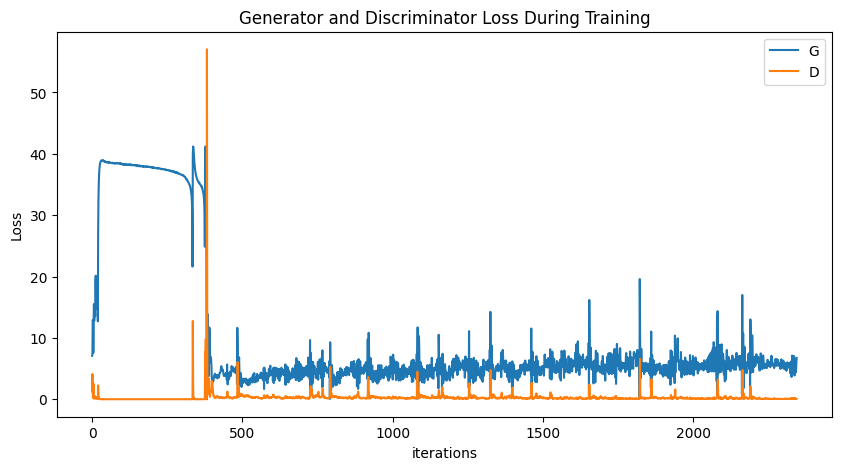

In [13]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

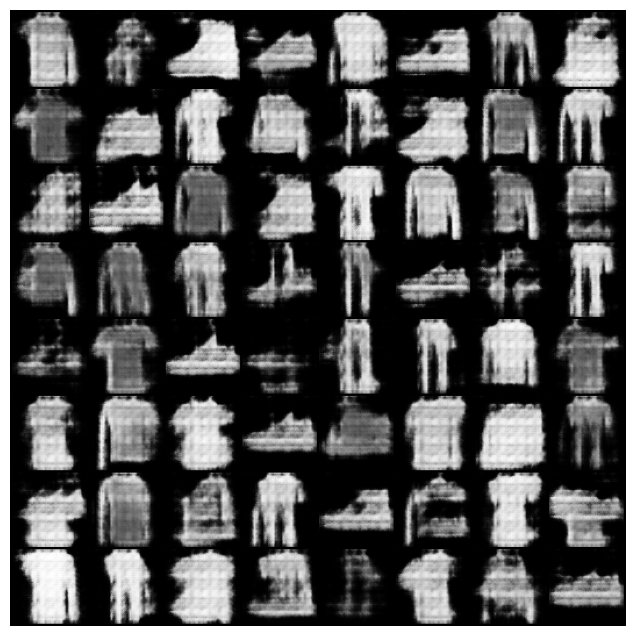

In [14]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

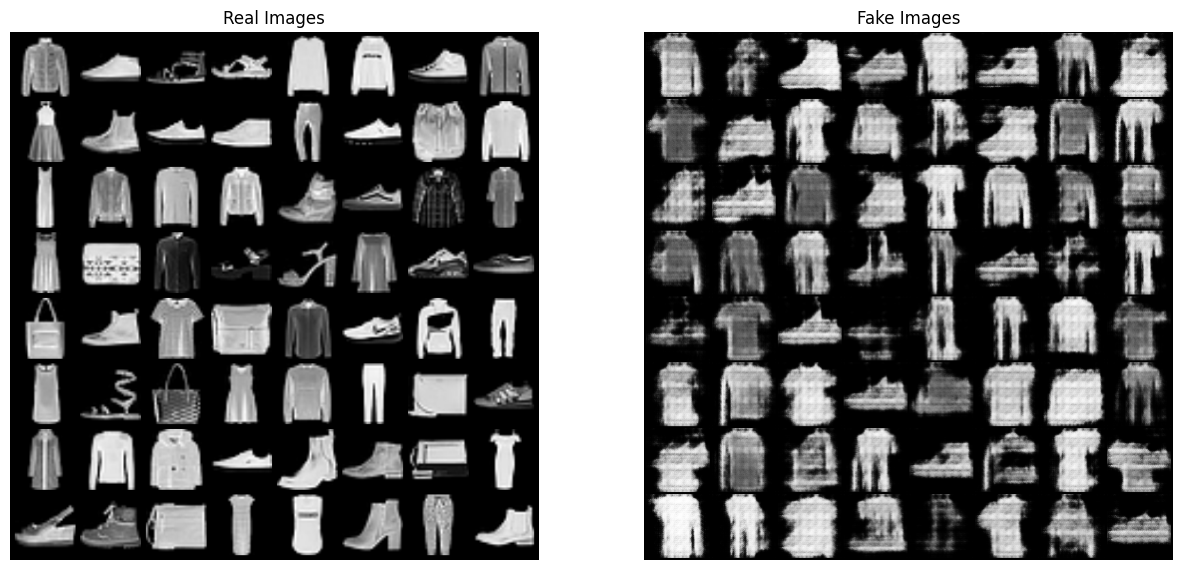

In [15]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()